## Documentation to support the publication: Updating the US National Fire Danger Rating System

### Purpose: Compare and contrast NFDRS V2/3 and V4 fuel models using the NFDRS calculator

<font size=5>NFDRSV4-TechDoc-FuelModelComparisonsAndFigures.ipynb</font><br>
W. Matt Jolly, william.jolly@usda.gov<br>
Patrick H. Freeborn, patrick.h.freeborn@usda.gov<br>
USDA Forest Service<br>
RMRS Fire Sciences Laboratory<br>
Fire, Fuel and Smoke Program<br>
5775 Hwy 10 W<br>
Missoula, MT 59808<br>

In [1]:
__author__ = 'mjolly'
import math
import sys, os
import pandas as pd
import matplotlib as plt
import numpy as np
from datetime import *
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from src.NFDRSV4Calc import *
from src.NFDRSV4PubGraphicsOptions import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
################################################################################################################
# First, we'll create a set of fuel moisture scenarios for the 4 dead and 2 live fuel moistures used in NFDRS
################################################################################################################

In [3]:
mySeed = 2016
def RandomizeFuelMoistureList(maxSim=100,mySeed = 2016):
    mySeed = [mySeed, mySeed+1, mySeed + 2, mySeed+3,mySeed+4,mySeed + 5]
    Params = []
    ParamsArr = []
    
    #### Get a Random Set of Parameters
    DFM = [ x + 1 for x in range(35) ]
    # We randomly sample over the ranges of herbaceous and woody LFMC
    HLFM = [ x + 30 for x in range(250) ]
    WLFM = [ x + 60 for x in range(200) ]
    d = {'DFM': DFM}
    hl = {'HLFM': HLFM}
    wl = {'WLFM': WLFM}
    
    dfdfm = pd.DataFrame(data=d)
    dfhlfm= pd.DataFrame(data=hl)
    dfwlfm= pd.DataFrame(data=wl)
    
    df1 = dfdfm.sample(n=maxSim,replace=True,random_state=mySeed[0])
    df2 = dfdfm.sample(n=maxSim,replace=True,random_state=mySeed[1])
    df3 = dfdfm.sample(n=maxSim,replace=True,random_state=mySeed[2])
    df4 = dfdfm.sample(n=maxSim,replace=True,random_state=mySeed[3])
    hlf = dfhlfm.sample(n=maxSim,replace=True,random_state=mySeed[4])
    wlf = dfwlfm.sample(n=maxSim,replace=True,random_state=mySeed[5]) 
    for i in range(0,maxSim):

        # Create a fuel moisture class instance
        fm = FuelMoisture()
        # Load the fuel moisture class with a random moisture scenario
        fm.MC1 = df1.iloc[i].DFM
        fm.MC10 = df2.iloc[i].DFM
        fm.MC100 = df3.iloc[i].DFM
        fm.MC1000 = df4.iloc[i].DFM
        fm.MCHERB = hlf.iloc[i].HLFM
        fm.MCWOOD = wlf.iloc[i].WLFM
        ParamsArr.append(fm)

    return ParamsArr 

In [4]:
mySeed = 2016
fmlist = RandomizeFuelMoistureList(maxSim=50000,mySeed=mySeed)

In [5]:
FMs = ['A','B','C','D','E','F','G','H','I','J','K','L','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
df = pd.DataFrame()
j = 0
for fm in FMs:
    ERCs = []
    ind = []
    print('Running sim for fuel model:',fm)
    iWS = 5               # Windspeed fixed at 5 mph... Note: ERC is not dependent on Windspeed, so this value won't affect the results
    iSlopeCls = 1         # Slope Class fixed at 1... Note: ERC is not dependent on Slope Class, so this value won't affect the results
    fGSI = 0.5            # GSI at 0.5 means fuels full cured
    KBDI = 100            # KBDI at 100 means no load transfer
    FuelTemperature = 25  # Fuel Temperature fixed at 25 deg C. Only affects IC
    
    # Create an instance of the Fuel Model class
    FM = USNFDRSFuelModel(fm)
    for i in fmlist:
        ind = iCalcIndexes (FM,i,iWS, iSlopeCls,fGSI, KBDI,FuelTemperature)
        ERCs.append(float(ind[0]))
    d = {fm:ERCs}

    if df.index.size == 0:
    #if j == 0:
        df = pd.DataFrame(data=d)
    else:
        df1 = pd.DataFrame(data=d)
        df = pd.concat([df,df1], axis=1)
    j = j + 1
        

Running sim for fuel model: A
Running sim for fuel model: B
Running sim for fuel model: C
Running sim for fuel model: D
Running sim for fuel model: E
Running sim for fuel model: F
Running sim for fuel model: G
Running sim for fuel model: H
Running sim for fuel model: I
Running sim for fuel model: J
Running sim for fuel model: K
Running sim for fuel model: L
Running sim for fuel model: N
Running sim for fuel model: O
Running sim for fuel model: P
Running sim for fuel model: Q
Running sim for fuel model: R
Running sim for fuel model: S
Running sim for fuel model: T
Running sim for fuel model: U
Running sim for fuel model: V
Running sim for fuel model: W
Running sim for fuel model: X
X
Running sim for fuel model: Y
Running sim for fuel model: Z


In [6]:
df.index.size

50000

In [7]:
pd.options.display.max_columns = 500

In [8]:
# Simulated ERC dataset for 20 V2 fuel models and 5 V4 fuel models
df.round(1)


,A,B,C,D,E,F,G,H,I,J,K,L,N,O,P,Q,R,S,T,U,V,W,X,Y,Z
0,0.1,8.8,3.1,13.8,9.0,0.0,29.2,4.6,140.5,75.5,28.3,0.2,10.9,24.7,21.2,13.2,2.2,4.6,1.3,5.7,0.0,0.9,21.2,29.9,39.5
1,0.0,6.2,2.9,8.9,5.3,3.5,5.0,2.4,103.7,68.2,20.2,0.0,7.6,30.1,8.4,17.8,5.1,4.0,0.0,11.3,0.0,0.3,12.2,4.6,33.4
2,0.0,1.4,2.3,11.8,8.7,0.0,8.4,0.9,87.2,53.3,17.3,0.1,8.1,21.9,11.7,12.2,3.9,4.1,0.3,7.0,0.0,0.2,16.3,8.3,26.8
3,0.0,0.0,1.0,1.9,0.0,0.0,0.0,0.0,8.9,5.2,1.9,0.0,1.7,11.6,5.4,2.3,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1.6
4,0.1,21.6,5.2,15.4,10.4,6.7,4.4,1.9,120.4,77.0,23.8,0.1,14.4,29.0,11.2,18.8,5.1,4.3,1.8,14.8,0.0,1.6,24.6,5.6,37.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.1,21.1,3.9,18.1,13.6,15.6,8.0,8.6,155.3,103.3,30.3,0.2,17.0,38.8,10.9,29.4,8.2,6.0,1.8,23.3,0.0,1.3,26.2,7.3,50.8
49996,0.0,0.0,0.0,0.3,0.0,0.0,38.1,4.3,62.3,29.9,12.1,0.0,0.0,17.6,12.4,3.6,0.2,2.4,0.0,0.0,0.0,0.0,0.0,31.7,18.4
49997,1.7,10.9,6.8,33.5,18.4,6.2,61.1,22.8,243.3,134.4,48.2,3.2,14.5,40.1,33.1,30.8,10.0,13.7,3.5,16.2,4.5,3.6,52.6,55.3,72.4
49998,0.0,0.0,0.0,2.8,1.4,0.0,31.6,7.0,89.2,49.7,17.3,0.0,0.0,23.7,11.8,8.9,1.9,3.5,0.0,0.0,0.0,0.0,0.3,26.1,27.9


In [9]:
# Cross-correlations between fuel models
df.corr().round(2)

,A,B,C,D,E,F,G,H,I,J,K,L,N,O,P,Q,R,S,T,U,V,W,X,Y,Z
A,1.00,0.39,0.57,0.76,0.74,0.40,0.12,0.33,0.32,0.34,0.32,0.99,0.50,0.25,0.36,0.42,0.65,0.55,0.76,0.50,0.92,0.73,0.75,0.13,0.33
B,0.39,1.00,0.81,0.71,0.72,0.88,0.21,0.49,0.63,0.67,0.63,0.35,0.87,0.62,0.48,0.75,0.69,0.62,0.81,0.86,0.24,0.81,0.77,0.25,0.63
C,0.57,0.81,1.00,0.78,0.70,0.68,0.19,0.43,0.59,0.62,0.59,0.57,0.82,0.58,0.52,0.74,0.80,0.70,0.79,0.80,0.54,0.89,0.80,0.22,0.59
D,0.76,0.71,0.78,1.00,0.94,0.66,0.21,0.49,0.60,0.63,0.60,0.73,0.88,0.55,0.55,0.74,0.82,0.73,0.85,0.78,0.60,0.81,0.99,0.24,0.61
E,0.74,0.72,0.70,0.94,1.00,0.73,0.26,0.58,0.66,0.70,0.67,0.69,0.87,0.60,0.57,0.76,0.83,0.75,0.81,0.84,0.52,0.74,0.94,0.29,0.68
F,0.40,0.88,0.68,0.66,0.73,1.00,0.30,0.65,0.70,0.74,0.70,0.36,0.76,0.72,0.49,0.82,0.78,0.70,0.72,0.92,0.25,0.70,0.70,0.32,0.72
G,0.12,0.21,0.19,0.21,0.26,0.30,1.00,0.85,0.80,0.74,0.80,0.11,0.23,0.72,0.89,0.58,0.36,0.72,0.17,0.34,0.08,0.16,0.21,1.00,0.78
H,0.33,0.49,0.43,0.49,0.58,0.65,0.85,1.00,0.93,0.92,0.93,0.30,0.51,0.89,0.86,0.84,0.70,0.90,0.43,0.71,0.23,0.41,0.50,0.85,0.93
I,0.32,0.63,0.59,0.60,0.66,0.70,0.80,0.93,1.00,0.99,1.00,0.29,0.69,0.96,0.92,0.94,0.76,0.94,0.52,0.80,0.20,0.50,0.61,0.82,1.00
J,0.34,0.67,0.62,0.63,0.70,0.74,0.74,0.92,0.99,1.00,0.99,0.31,0.73,0.98,0.88,0.96,0.80,0.94,0.54,0.85,0.21,0.53,0.64,0.76,1.00


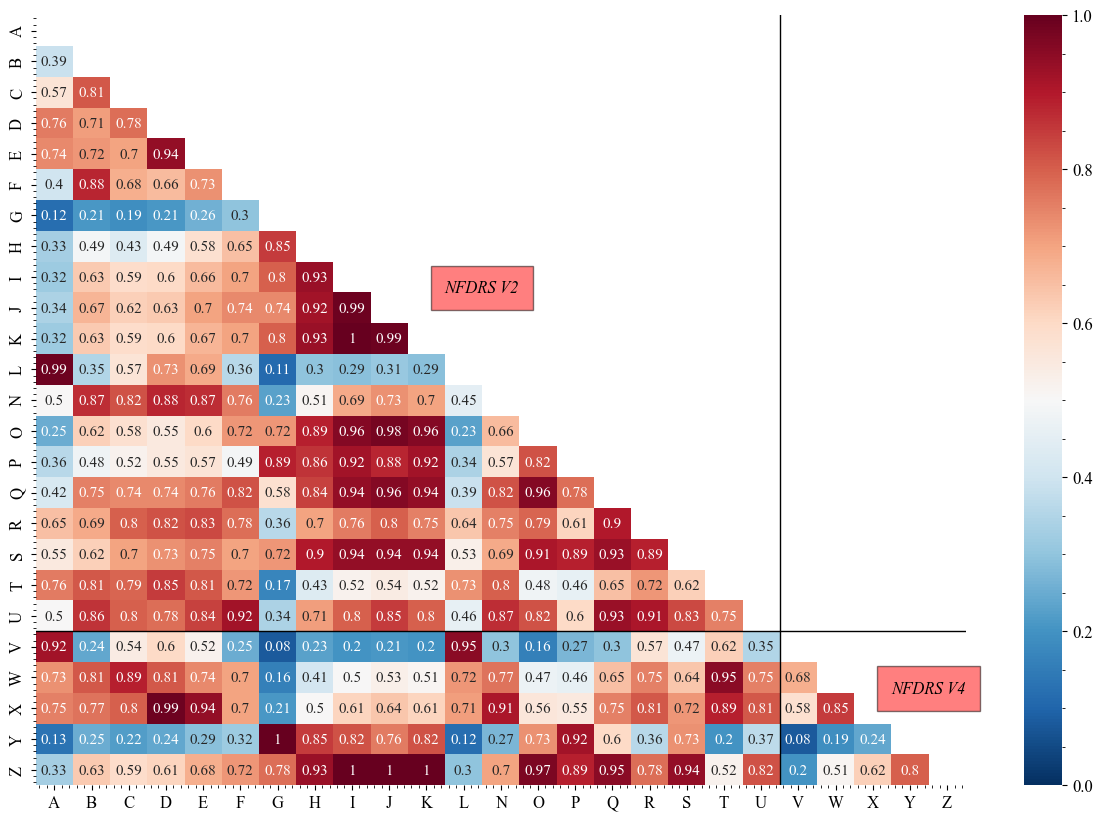

In [10]:
mpl.rcParams['axes.grid']='False'

f,ax = plt.subplots(figsize=(15,10))
#plt.title('NFDRS Fuel Model Cross-Correlations', fontsize=16)
plt.xlabel('Fuel Model', fontsize=14)
plt.ylabel('Fuel Model', fontsize=14)
correlations = df.corr()
matrix = np.triu(correlations)
sns.heatmap(round(correlations,2), cmap='RdBu_r', annot=True, 
            annot_kws={"size": 11}, vmin=0, vmax=1, mask=matrix);
plt.axvline(20, 0,1,c='black')
plt.axhline(20, 0,1,c='black')
plt.gca().text(23, 22, 'NFDRS V4', style='italic', bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.gca().text(11, 9, 'NFDRS V2', style='italic', bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})

fout="./outputs/FuelModelCorrelogram.png"
if(fout != ""):
        plt.savefig(fout, dpi=300, bbox_inches='tight',facecolor='white',transparent=False)

<Figure size 1200x500 with 0 Axes>

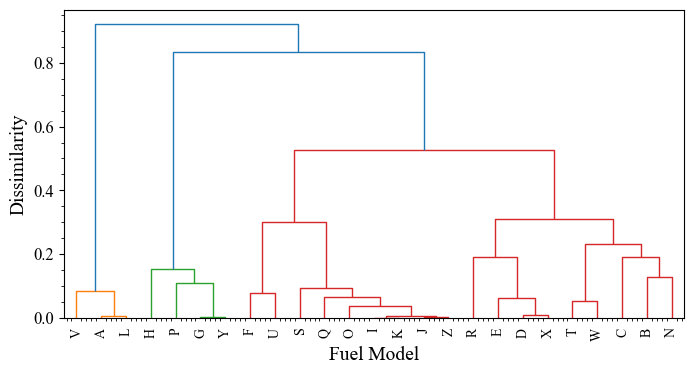

In [11]:
plt.figure(figsize=(12,5))
dissimilarity = 1 - abs(correlations)
Z = linkage(squareform(dissimilarity), 'complete')
plt.figure(figsize=(8,4))
#plt.title('Hierarchical Clustering of Energy Release Component', fontsize=16)
plt.xlabel('Fuel Model', fontsize=14)
plt.ylabel('Dissimilarity', fontsize=14)
dendrogram(Z, labels=df.columns, orientation='top', 
           leaf_rotation=90);
#plt.hlines(0.3)
fout="./outputs/FuelModelHierClust.png"
if(fout != ""):
        plt.savefig(fout, dpi=300, bbox_inches='tight',facecolor='white',transparent=False)